# TGA Weight Loss Analysis

> [Return to Examples List](README.md)

This notebook demonstrates how to perform an analysis of TGA data, leveraging key temperature points to identify weight loss steps and calculate weight fractions.

## Load Experiment Data

First, let's load the experiment data from a JSON file and convert it into a Pandas DataFrame.

In [1]:
from tadatakit.classes import Experiment

# Load the experiment data
experiment = Experiment.from_json("files/TGA - Aspirin.json")
df = experiment.get_dataframe()

## Define Helper Function

We need a helper function to find the closest value in a series to a target value.

In [2]:
import numpy as np


def find_closest_values(series, target):
    """Find the closest value in a series to the target value"""
    idx = (np.abs(series - target)).argmin()
    return idx, series[idx]

## Identify Key Temperature Points and Calculate Weight Loss

We'll identify key temperature points and use them to calculate the weight loss.

In [3]:
# Define target temperatures
temp_1 = 100
temp_2 = 225
temp_3 = 450

# Find the closest indices and actual temperatures
t1_idx, t1_actual = find_closest_values(df["Temperature / °C"], temp_1)
t2_idx, t2_actual = find_closest_values(df["Temperature / °C"], temp_2)
t3_idx, t3_actual = find_closest_values(df["Temperature / °C"], temp_3)

# Calculate weight fractions
first_drop_to = df.iloc[t2_idx]["Weight / %"]
residual = df.iloc[t3_idx:]["Weight / %"].mean()

## Plot Weight and First Derivative

We'll plot the weight on a primary y-axis and its first derivative on a secondary y-axis.

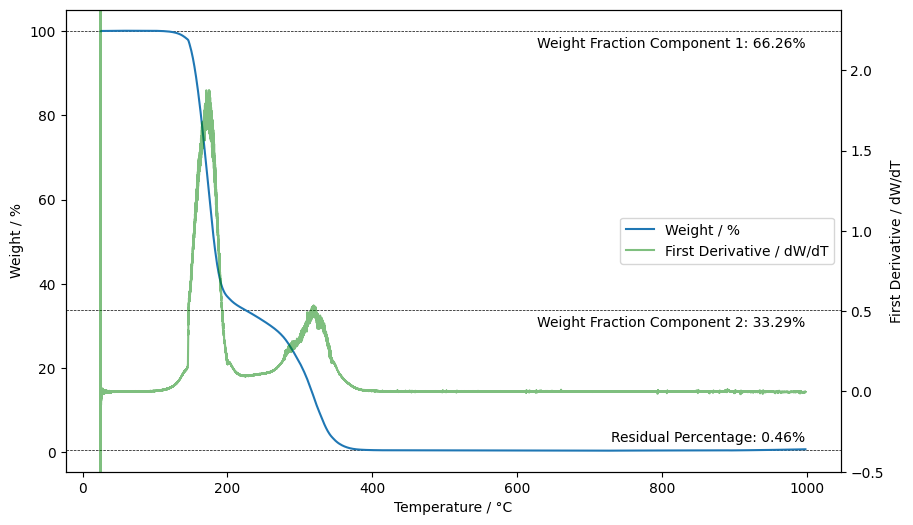

In [4]:
import matplotlib.pyplot as plt

# Calculate the first derivative of weight with respect to temperature
derivative = -np.gradient(df["Weight / %"], df["Temperature / °C"])

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Add horizontal lines for weight fractions
ax1.axhline(100, color="k", linestyle="--", linewidth=0.5)
ax1.axhline(first_drop_to, color="k", linestyle="--", linewidth=0.5)
ax1.axhline(residual, color="k", linestyle="--", linewidth=0.5)

# Annotate weight fractions
x_offset = 3
ax1.text(
    df["Temperature / °C"].iloc[-1],
    100 - x_offset,
    f"Weight Fraction Component 1: {100 - first_drop_to:.2f}%",
    va="center",
    ha="right",
)
ax1.text(
    df["Temperature / °C"].iloc[-1],
    first_drop_to - x_offset,
    f"Weight Fraction Component 2: {first_drop_to - residual:.2f}%",
    va="center",
    ha="right",
)
ax1.text(
    df["Temperature / °C"].iloc[-1],
    residual + x_offset,
    f"Residual Percentage: {residual:.2f}%",
    va="center",
    ha="right",
)

# Plot weight percentage
ax1.plot(df["Temperature / °C"], df["Weight / %"], label="Weight / %")

# Plot derivative
ax2.plot(
    df["Temperature / °C"],
    derivative,
    color="green",
    alpha=0.5,
    label="First Derivative / dW/dT",
)
ax2.set_ylim(-0.5, derivative[500:].max() + 0.5)


ax1.set_xlabel("Temperature / °C")
ax1.set_ylabel("Weight / %")
ax2.set_ylabel("First Derivative / dW/dT")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")
plt.show()

## Extract Weight Fractions From TRIOS Analyses And Compare
The file has the same analysis performed in TRIOS, so we can pull those out and compare with our calculations here in Python.

In [5]:
import pandas as pd

weight_fractions = []
for analysis in experiment.analyses:
    if analysis.type.name == "Weight change":
        start_temp, end_temp = sorted(
            [
                v["Value"]["Value"]
                for k, v in analysis.inputs.to_dict().items()
                if k.startswith("Cursor")
            ]
        )
        weight_fractions.append(
            {
                "Start Temperature / °C": start_temp,
                "End Temperature / °C": end_temp,
                "TRIOS Weight / %": analysis.outputs.to_dict()["Weight Percent Loss"][
                    "Value"
                ]["Value"],
            }
        )
    elif analysis.type.name == "Residue":
        weight_fractions.append(
            {
                "Start Temperature / °C": analysis.inputs.to_dict()["Cursor x"][
                    "Value"
                ]["Value"],
                "TRIOS Weight / %": analysis.outputs.to_dict()["Residue Percent"][
                    "Value"
                ]["Value"],
            }
        )

# Add in the previously calculated weight fractions and display
weight_fractions = pd.DataFrame(weight_fractions)
weight_fractions["Python Weight / %"] = [
    100 - first_drop_to,
    first_drop_to - residual,
    residual,
]
weight_fractions.round(1)

,Start Temperature / °C,End Temperature / °C,TRIOS Weight / %,Python Weight / %
0,68.3,225.0,66.4,66.3
1,225.0,435.8,33.3,33.3
2,995.5,NaN,0.7,0.5
